<a href="https://colab.research.google.com/github/JanaSchwarzerova/PGine/blob/BIBM2023/cPRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Polygenic Risk Score Calculation using Conventional approach**


---


The implementation of conventional Polygenic Risk Score (cPRS)  


---
Three experiments:


1.   *A. thaliana* – data from Weiszmann et al. [1]
2.   Barley – data from Gemmer et al. [2]
3.   **Maize – data from Millet et al. [3]** (example on maize)





In [1]:
! pip install scikit-multiflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.6/450.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-multiflow: filename=scikit_multiflow-0.5.3-cp310-cp310-linux_x86_64.whl size=1254678 sha256=e8c22ec3d134ce8a6102342b739dd13d004411ac04682f861410ddb662d40de5
  Stored in directory: /root/.cache/pip/wheels/6e/1b/56/45b17a6cf203d98000a45976cb0dd0c4c3f11960e6a505f231
Successfully built scikit-multiflow


Installation – Libraries & Packages

In [2]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading data:**

In [4]:
#Load data

gen = '/content/drive/MyDrive/PRS/Data/Maize_Genotype.csv'
phe = '/content/drive/MyDrive/PRS/Data/Maize_Phenotype.csv'

genotype_data = pd.read_csv(gen, delimiter=',')
phenotype_data = pd.read_csv(phe, delimiter=',')

**Conventional Polygenic Risk Score (cPRS):**

Genome-wide association study (GWAS)

In [7]:
def genome_wide_association_study_with_cv(genotype_data, phenotype_data):
    """
    Computes a genome-wide association study using 5-fold cross-validation.

    :param genotype_data: (dataframe) matrix represents SNP information
    :param phenotype_data: (dataframe) represents phenotype information (healthy / sick)
    :return: p-values, effect size (alias effect alleles) and Manhattan plot
    """

    # Merge genotype and phenotype data by sample ID
    data = pd.merge(genotype_data, phenotype_data, on='Ind')

    # Initialize lists to store results
    results = []
    significant_results = []
    genotype_data_columns = genotype_data.columns.drop('Ind')

    # Define the number of folds for cross-validation
    num_folds = 5
    kf = KFold(n_splits=num_folds)

    for snp in genotype_data_columns:
        X = pd.to_numeric(data[snp])
        X = sm.add_constant(X)
        y = data['phenotype']

        p_values = []  # Store p-values from each fold
        beta_values = []

        # Perform 5-fold cross-validation
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model = sm.OLS(y_train, X_train).fit()  # Fit linear regression model on training data
            p_value = model.pvalues[snp]  # Calculate p-value on test data
            beta = model.params[snp]  # Coefficient represents effect size

            p_values.append(p_value)
            beta_values.append(beta)

        # Calculate the mean p-value from cross-validation
        mean_p_value = sum(p_values) / num_folds
        mean_beta = sum(beta_values) / num_folds

        results.append({'SNP': snp, 'P-Value': mean_p_value, 'Effect Size (Beta)': mean_beta})

        # Check if the mean p-value is below the Bonferroni-corrected threshold
        alpha = 0.05  # Define the significance level (alpha) for Bonferroni correction
        num_tests = len(genotype_data_columns)
        bonferroni_threshold = alpha / num_tests

        if mean_p_value <= bonferroni_threshold:
            significant_results.append({'SNP': snp, 'P-Value': mean_p_value, 'Effect Size (Beta)': mean_beta})

    results_df = pd.DataFrame(results)
    #results_df.to_csv("results_GWAS.csv")

    significant_results_df = pd.DataFrame(significant_results)
    #significant_results_df.to_csv("significant_results_GWAS.csv")

    # Return both results and significant results dataframes
    return results_df, significant_results_df

In [8]:
results, significant_results = genome_wide_association_study_with_cv(genotype_data, phenotype_data)

Polygenic Risk Score



In [14]:
results_df = pd.DataFrame(results)
effect_sizes = results_df.drop('P-Value', axis=1)

In [15]:

# .............................................................
# Calculate the Polygenic Risk Score

alleles = genotype_data.T
alleles = alleles.drop(alleles.index[0])
alleles_np = alleles.to_numpy()
effect_sizes_np = effect_sizes['Effect Size (Beta)'].to_numpy()
prs_values = []

for ind in range(0, len(alleles.columns)):
    prs = (alleles_np[:, ind] * effect_sizes_np).sum()
    prs_values.append(prs)

# Create a DataFrame from the prs_values list
prs_df = pd.DataFrame(prs_values)

Visualization

In [16]:
# Vizualization – phenotype distribution according mean value
phenotype_data_withPRS = phenotype_data
phenotype_data_withPRS['PRS'] = prs_values
mean_value = phenotype_data_withPRS['phenotype'].mean()
above_mean_data = phenotype_data_withPRS[phenotype_data_withPRS['phenotype'] > mean_value]
below_mean_data = phenotype_data_withPRS[phenotype_data_withPRS['phenotype'] < mean_value]

Visualization of data distribution based on **phenotype**

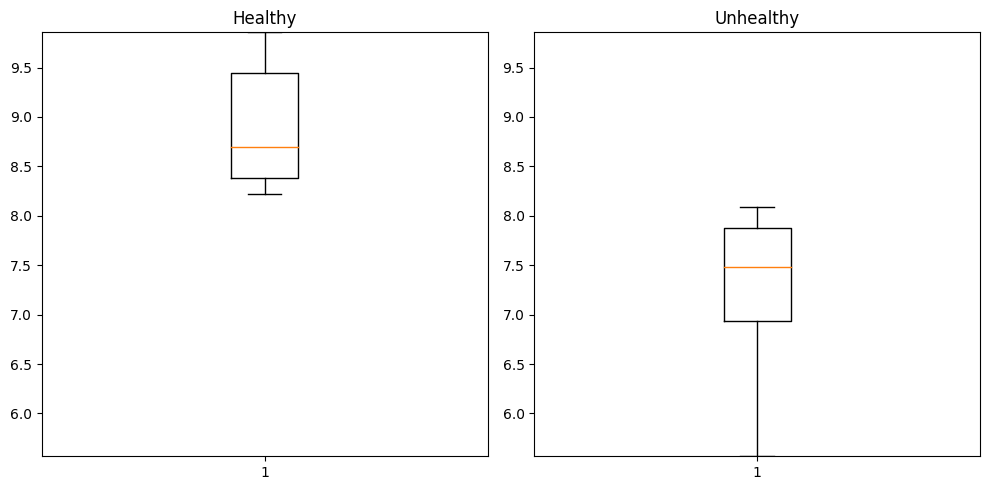

In [17]:
# using boxplot:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(above_mean_data['phenotype'].dropna())
plt.title('Healthy')
plt.ylim(min(phenotype_data_withPRS['phenotype']), max(phenotype_data_withPRS['phenotype']))

plt.subplot(1, 2, 2)
plt.boxplot(below_mean_data['phenotype'].dropna())
plt.title('Unhealthy')
plt.ylim(min(phenotype_data_withPRS['phenotype']), max(phenotype_data_withPRS['phenotype']))

# Show the plot
plt.tight_layout()
plt.show()


Visualization of data distribution based on **PRS**

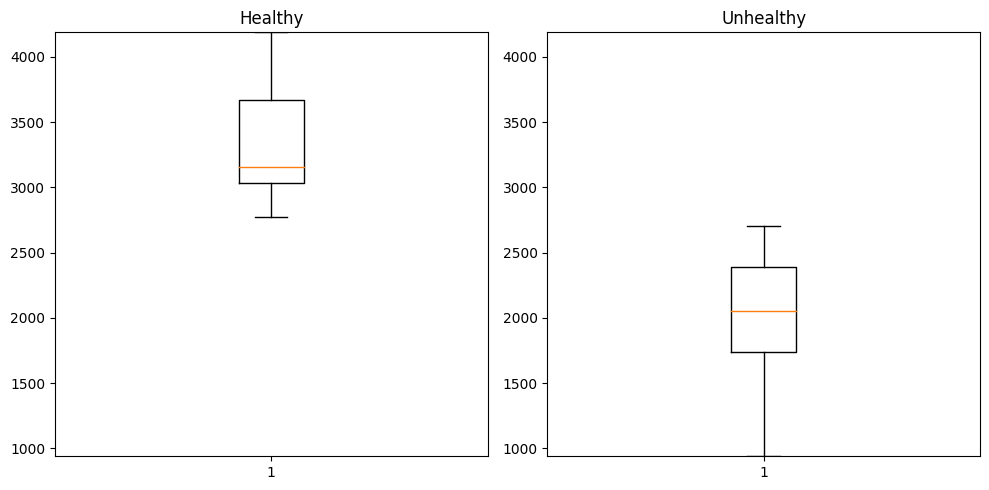

In [18]:
# using boxplot:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(above_mean_data['PRS'].dropna())
plt.title('Healthy')
plt.ylim(min(phenotype_data_withPRS['PRS']), max(phenotype_data_withPRS['PRS']))

plt.subplot(1, 2, 2)
plt.boxplot(below_mean_data['PRS'].dropna())
plt.title('Unhealthy')
plt.ylim(min(phenotype_data_withPRS['PRS']), max(phenotype_data_withPRS['PRS']))

# Show the plot
plt.tight_layout()
plt.show()

**Literature**

[1] Weiszmann, Jakob, et al. "Metabolome plasticity in 241 Arabidopsis thaliana accessions reveals evolutionary cold adaptation processes." Plant Physiology (2023): kiad298.

[2] Gemmer, M.R., Richter, C., Jiang, Y., Schmutzer, T., Raorane, M.L., Junker, B., Pillen, K. and Maurer, A., 2020. Can metabolic prediction be an alternative to genomic prediction in barley?. PLoS One, 15(6), p.e0234052.

[3] Millet, E.J., Welcker, C., Kruijer, W., Negro, S., Coupel-Ledru, A., Nicolas, S.D., Laborde, J., Bauland, C., Praud, S., Ranc, N. and Presterl, T., 2016. Genome-wide analysis of yield in Europe: allelic effects vary with drought and heat scenarios. Plant Physiology, 172(2), pp.749-764.